In [1]:
import pandas as pd
import urllib
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [19]:
customer = pd.read_csv("data/olist_customers_dataset.csv")
order = pd.read_csv("data/olist_orders_dataset.csv")
item = pd.read_csv("data/olist_order_items_dataset.csv")

In [12]:
customer.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [13]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [14]:
customer.groupby('customer_unique_id').size().sort_values(ascending=False)
#customer.groupby('customer_id').size().sort_values(ascending=False)

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
6469f99c1f9dfae7733b25662e7f1782     7
ca77025e7201e3b30c44b472ff346268     7
1b6c7548a2a1f9037c1fd3ddfed95f33     7
                                    ..
5657dfebff5868c4dc7e8355fea865c4     1
5657596addb4d7b07b32cd330614bdf8     1
5656eb169546146caeab56c3ffc3d268     1
5656a8fabc8629ff96b2bc14f8c09a27     1
ffffd2657e2aad2907e67c3e9daecbeb     1
Length: 96096, dtype: int64

In [20]:
item.describe(include='all')

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
count,112650,112650.000000,112650,112650,112650,112650.000000,112650.000000
unique,98666,NaN,32951,3095,93318,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23,NaN,NaN
freq,21,NaN,527,2033,21,NaN,NaN
mean,NaN,1.197834,NaN,NaN,NaN,120.653739,19.990320
std,NaN,0.705124,NaN,NaN,NaN,183.633928,15.806405
min,NaN,1.000000,NaN,NaN,NaN,0.850000,0.000000
25%,NaN,1.000000,NaN,NaN,NaN,39.900000,13.080000
50%,NaN,1.000000,NaN,NaN,NaN,74.990000,16.260000
75%,NaN,1.000000,NaN,NaN,NaN,134.900000,21.150000


<AxesSubplot:>

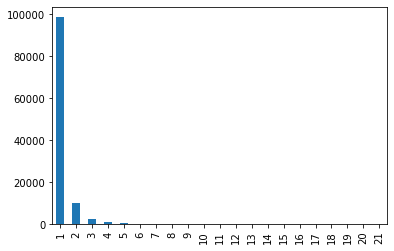

In [21]:
CountStatus = pd.value_counts(item['order_item_id'].values, sort=True)
CountStatus.plot.bar()

## Data Merging

In [27]:
order_items_silver = item.groupby('order_id').agg({'price':sum,'freight_value':sum }).reset_index()
order_silver=order.merge(order_items_silver,on='order_id',how='inner')
orders_customers = customer.merge(order_silver, on='customer_id', how='inner')
orders_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98666 entries, 0 to 98665
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    98666 non-null  object 
 1   customer_unique_id             98666 non-null  object 
 2   customer_zip_code_prefix       98666 non-null  int64  
 3   customer_city                  98666 non-null  object 
 4   customer_state                 98666 non-null  object 
 5   order_id                       98666 non-null  object 
 6   order_status                   98666 non-null  object 
 7   order_purchase_timestamp       98666 non-null  object 
 8   order_approved_at              98652 non-null  object 
 9   order_delivered_carrier_date   97657 non-null  object 
 10  order_delivered_customer_date  96476 non-null  object 
 11  order_estimated_delivery_date  98666 non-null  object 
 12  price                          98666 non-null 

## RFM Variable

In [29]:
max_date = max(pd.to_datetime(orders_customers['order_purchase_timestamp'],  errors='raise')) + datetime.timedelta(days=1)
max_date

Timestamp('2018-09-04 09:06:57')

In [30]:
rfm=orders_customers.groupby('customer_unique_id').agg(
        {'order_purchase_timestamp':lambda x:(max_date-pd.to_datetime(x.max())).days,
         'customer_id':'count',
         'price':'sum'
       }).reset_index()

rfm.columns=['customer_id','recency','frequency','monetary']

In [31]:
rfm['recency'].describe()

count    95420.000000
mean       243.600377
std        153.160320
min          1.000000
25%        119.000000
50%        224.000000
75%        353.000000
max        729.000000
Name: recency, dtype: float64

<AxesSubplot:xlabel='recency', ylabel='Count'>

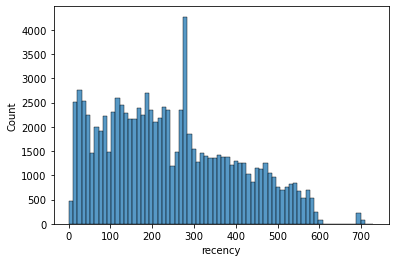

In [32]:
sns.histplot(rfm['recency'])

In [33]:
rfm['frequency'].describe()

count    95420.000000
mean         1.034018
std          0.211234
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: frequency, dtype: float64

In [34]:
rfm['monetary'].describe()

count    95420.000000
mean       142.440198
std        217.656355
min          0.850000
25%         47.900000
50%         89.900000
75%        155.000000
max      13440.000000
Name: monetary, dtype: float64

## K-means grouping

In [35]:
def k_means_group(data, n_clusters, random_state, asc=False, log_transf=False, standard_tranf=False):
    
    data_temp = data.copy()
    if log_transf:
        data_temp = np.log(data_temp) + 1
        
    if standard_tranf:
        scaler = StandardScaler()
        scaler = scaler.fit(data_temp)
        data_temp = scaler.transform(data_temp)
        
    kmeans_sel = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data_temp)
    
    cluster_group = data.assign(cluster = kmeans_sel.labels_)
    
    mean_group = cluster_group.groupby('cluster').mean().reset_index()
    mean_group = mean_group.sort_values(by=mean_group.columns[1],ascending=asc)
    mean_group['cluster_set'] = [i for i in range(n_clusters, 0, -1) ]
    
    cluster_map = mean_group.set_index('cluster').to_dict()['cluster_set']
    
    return cluster_group['cluster'].map(cluster_map)

In [36]:
r_labels = k_means_group(rfm[['recency']],5,1,asc=True)
f_labels = k_means_group(rfm[['frequency']],5,1)
m_labels = k_means_group(rfm[['monetary']],5,1)

rfm = rfm.assign(R = r_labels, F = f_labels, M = m_labels)

In [37]:
rfm.groupby('R')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
R,,,,,,,,
1,12385.0,514.573759,50.444994,447.0,474.0,507.0,546.0,729.0
2,15934.0,379.632672,35.570759,321.0,349.0,379.0,410.0,446.0
3,22881.0,262.040208,31.058581,209.0,234.0,266.0,284.0,320.0
4,24281.0,155.651950,30.192414,105.0,129.0,155.0,182.0,208.0
5,19939.0,52.518080,27.072252,1.0,29.0,48.0,76.0,104.0


In [38]:
rfm.groupby('F')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
F,,,,,,,,
1,92507.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,2673.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
3,221.0,3.131222,0.338409,3.0,3.0,3.0,3.0,4.0
4,18.0,5.833333,1.098127,5.0,5.0,5.5,6.0,9.0
5,1.0,16.000000,NaN,16.0,16.0,16.0,16.0,16.0
